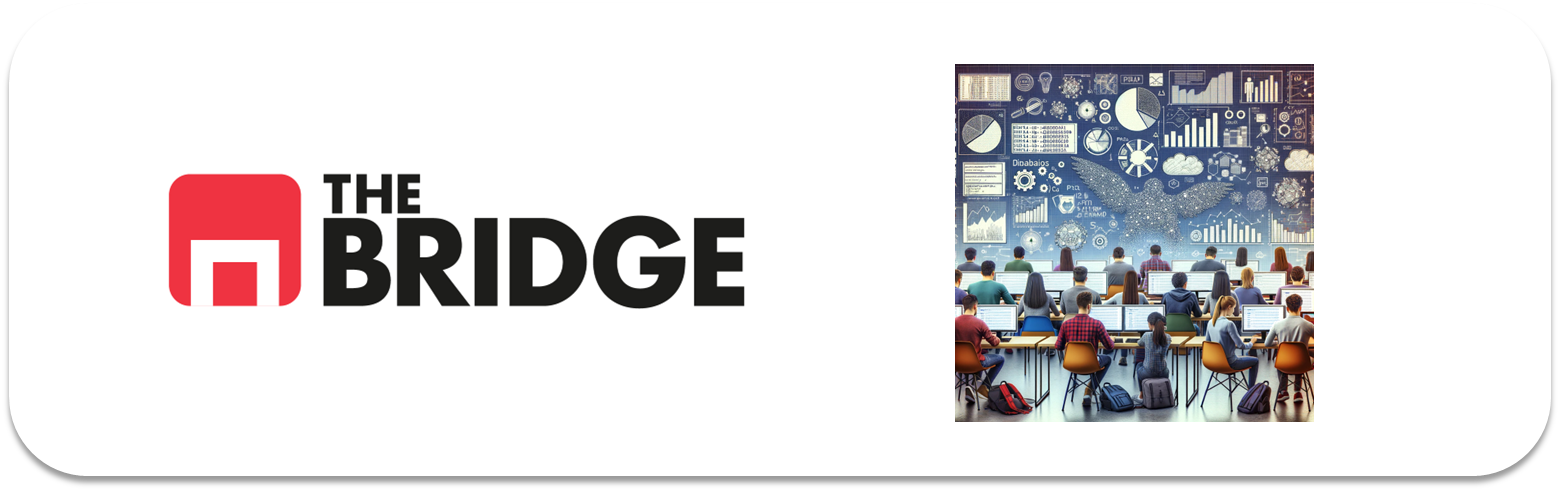

## PRACTICA OBLIGATORIA: **Clasificacion y Regresion Logistica**

* La práctica obligatoria de esta unidad consiste en modelar la supervivencia en el Titanic, por fin, además de una parte adicional multiclase. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Indicaciones

A continuación tienes las indicaciones para hacer el modelado. No necesariamente tienes que seguirlos al pie de la letra, porque a partir de ahora ya las práctica obligatorias dejarán de ser mayormente guiadas por ejercicios y serán más de libre desarrollo, aunque con objetivos específicos, claros y determinados. 

En concreto se pide hacer un modelo de regresión logística, evaluarlo contra un dataset de test reservado del original mostrando las métricas propias de los problemas de clasificación, la matriz de confusión y la curva ROC. Además se pide comparar las predicciones con los valores reales y al final adaptar el modelo a un problema multiclase.

Los pasos para guiar el trabajo:
1. Carga el dataset del Titanic. 

2. Deshazte de las variables que no vayas a usar. Limpia lo que creas necesarios pero no hagas imputaciones. 

In [2]:
df = pd.read_csv("./data/titanic.csv")
df.info()
df.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
113,0,3,female,20.0,1,0,9.8250,S,Third,woman,False,NaN,Southampton,no,False
836,0,3,male,21.0,0,0,8.6625,S,Third,man,True,NaN,Southampton,no,True
587,1,1,male,60.0,1,1,79.2000,C,First,man,True,B,Cherbourg,yes,False
17,1,2,male,NaN,0,0,13.0000,S,Second,man,True,NaN,Southampton,yes,True
620,0,3,male,27.0,1,0,14.4542,C,Third,man,True,NaN,Cherbourg,no,False
652,0,3,male,21.0,0,0,8.4333,S,Third,man,True,NaN,Southampton,no,True
521,0,3,male,22.0,0,0,7.8958,S,Third,man,True,NaN,Southampton,no,True
281,0,3,male,28.0,0,0,7.8542,S,Third,man,True,NaN,Southampton,no,True
379,0,3,male,19.0,0,0,7.7750,S,Third,man,True,NaN,Southampton,no,True
759,1,1,female,33.0,0,0,86.5000,S,First,woman,False,B,Southampton,yes,True


In [3]:
df["who"].value_counts()

who
man      537
woman    271
child     83
Name: count, dtype: int64

In [4]:
# Completamos los faltantes
df["deck"] = df.deck.fillna("UNK") # El porcentaje de faltante es muy alto y emos defidido reclasificarlos.
df["age"] = df["age"].fillna(df.groupby("who")["age"].transform("mean")) # Completamos los faltantes con los valores de edad media para cada subgrupo 'who'

moda_embarked = df["embarked"].mode()[0]
df["embarked"] = df["embarked"].fillna(moda_embarked) # Completamos los faltantes con la moda

In [5]:
# Realizo un one-hot encoding de las variables categóricas
df["sex_male"] = (df["sex"] == "male").astype(int)
df = pd.get_dummies(df, columns=["embarked"], drop_first=True)
df["class"] = df["class"].map({"First": 1, "Second": 2, "Third": 3})
df = pd.get_dummies(df, columns=['who'], drop_first=True)

In [6]:
target = "survived"
features_removed = ["embark_town", "alive", "class", "adult_male", "sex", "deck"]
df.drop(columns=features_removed, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   survived    891 non-null    int64  
 1   pclass      891 non-null    int64  
 2   age         891 non-null    float64
 3   sibsp       891 non-null    int64  
 4   parch       891 non-null    int64  
 5   fare        891 non-null    float64
 6   alone       891 non-null    bool   
 7   sex_male    891 non-null    int64  
 8   embarked_Q  891 non-null    bool   
 9   embarked_S  891 non-null    bool   
 10  who_man     891 non-null    bool   
 11  who_woman   891 non-null    bool   
dtypes: bool(5), float64(2), int64(5)
memory usage: 53.2 KB


3. Escoge y analiza la variable target de forma gráfica y razona sobre el impacto de la distribución en los resultados esperados. Ten en cuenta que lo que queremos es poder predecir si un pasajero sobrevivirá.

<Axes: xlabel='survived', ylabel='percent'>

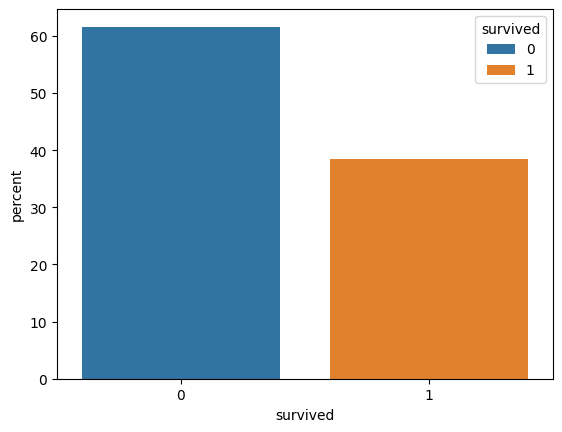

In [8]:
sns.countplot(x = target, data = df, hue = target, stat = "percent")
# Está bastante balanceado, aprox. 60% no sobrevivieron y el 40% sí

array([[<Axes: title={'center': 'survived'}>,
        <Axes: title={'center': 'pclass'}>,
        <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'sibsp'}>,
        <Axes: title={'center': 'parch'}>,
        <Axes: title={'center': 'fare'}>],
       [<Axes: title={'center': 'sex_male'}>, <Axes: >, <Axes: >]],
      dtype=object)

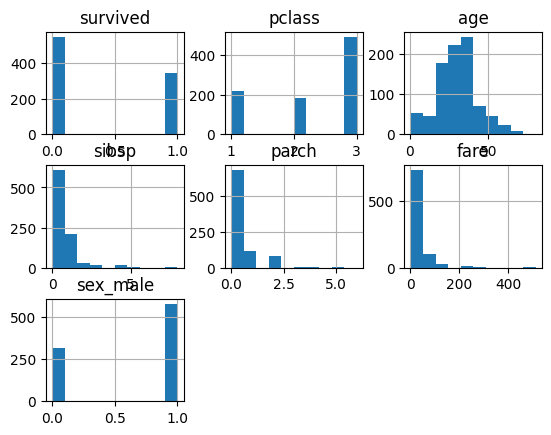

In [9]:
df.hist()

'Survivided' es booleana, categórica  
'pclass' también es categórica

Vemos que podemos aplicar transformaciones logaritmicas pues 'sibsp', 'fare', 'parch' presentan una heavy tail.

4. Haz el split en train y test que creas conveniente pero asegurándote que ambos conjuntos tienen un reparto similar de pasajeros embarcados en las tres ciudades.

In [10]:
train_set, test_set = train_test_split(df, test_size= 0.2, random_state= 42)
train_set.describe().T

,count,mean,std,min,25%,50%,75%,max
survived,712.0,0.376404,0.484824,0.00,0.000,0.0000,1.0,1.0000
pclass,712.0,2.330056,0.824584,1.00,2.000,3.0000,3.0,3.0000
age,712.0,30.158706,13.064724,0.42,22.000,32.0000,35.0,80.0000
sibsp,712.0,0.553371,1.176404,0.00,0.000,0.0000,1.0,8.0000
parch,712.0,0.379213,0.791669,0.00,0.000,0.0000,0.0,6.0000
fare,712.0,32.586276,51.969529,0.00,7.925,14.4542,30.5,512.3292
sex_male,712.0,0.655899,0.475408,0.00,0.000,1.0000,1.0,1.0000


In [11]:
test_set.describe().T

,count,mean,std,min,25%,50%,75%,max
survived,179.0,0.413408,0.493826,0.00,0.0000,0.0,1.0000,1.000
pclass,179.0,2.223464,0.877501,1.00,1.0000,3.0,3.0000,3.000
age,179.0,30.958876,13.077303,0.83,22.0000,32.0,36.0000,71.000
sibsp,179.0,0.402235,0.730703,0.00,0.0000,0.0,1.0000,4.000
parch,179.0,0.391061,0.863185,0.00,0.0000,0.0,0.0000,5.000
fare,179.0,30.684473,39.447725,0.00,7.8958,14.5,32.4104,262.375
sex_male,179.0,0.614525,0.488073,0.00,0.0000,1.0,1.0000,1.000


5. Construye las parejas X,y de train y test.

In [12]:
X_train = train_set.drop(target, axis = 1)
X_test = test_set.drop(target, axis = 1)
y_train = train_set[target]
y_test = test_set[target]

6. Ahora sí imputa los nulos con medias y modas en la X de train. Guarda esas medias que necesitarás en la parte de test.

Ya está realizado en el primer punto

7. Haz un mini-EDA, selecciona las features que quieres quedarte y por qué.

In [13]:
df_eda = X_train.copy()
df_eda["target"] = y_train.copy()
np.abs(df_eda.corr()['target']).sort_values(ascending=False)


target        1.000000
who_man       0.555530
sex_male      0.541750
who_woman     0.511542
pclass        0.321750
fare          0.246641
alone         0.180542
embarked_S    0.134623
parch         0.078311
age           0.070082
sibsp         0.047602
embarked_Q    0.006097
Name: target, dtype: float64

Vamos a seleccionar variables con una correlación superior al 0,1

In [14]:
corr = np.abs(df_eda.corr()['target']).sort_values(ascending=False)
# Features con menos de 0.1 de correlación vs el target
bad_corr_feat = corr[corr < 0.1].index.values
# Filtramos las columnas buenas
df_eda.drop(columns=bad_corr_feat, inplace=True)

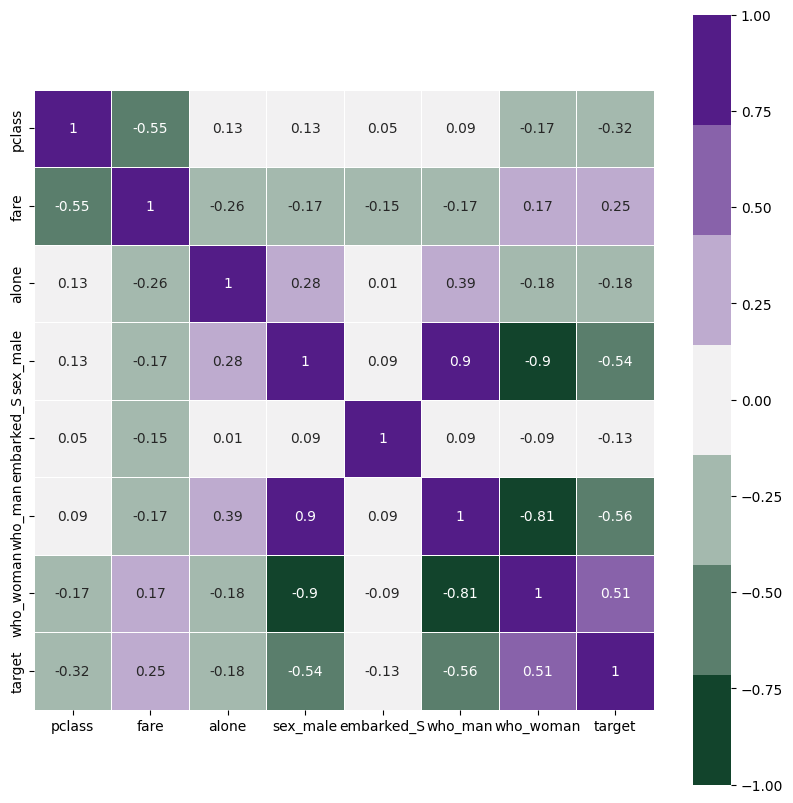

In [15]:
plt.figure(figsize=(10,10))
sns.heatmap(np.round(df_eda.corr(), 2),
            vmin=-1,
            vmax=1,
            annot=True,
            cmap=sns.diverging_palette(145, 280, s=85, l=25, n=7),
            square=True,
            linewidths=.5);

8. Trata las variables para que funcionen lo mejor posible en el modelo.

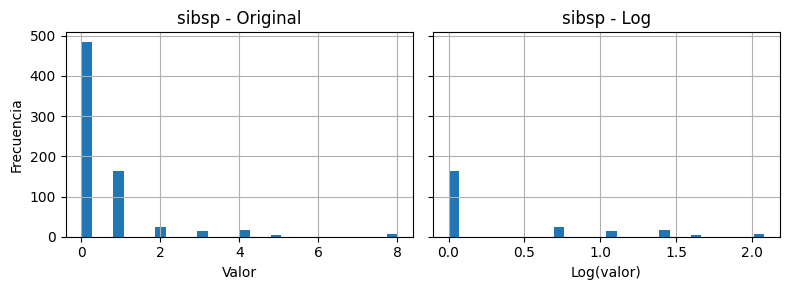

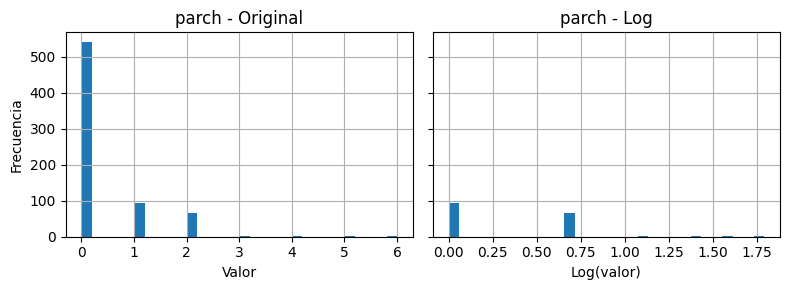

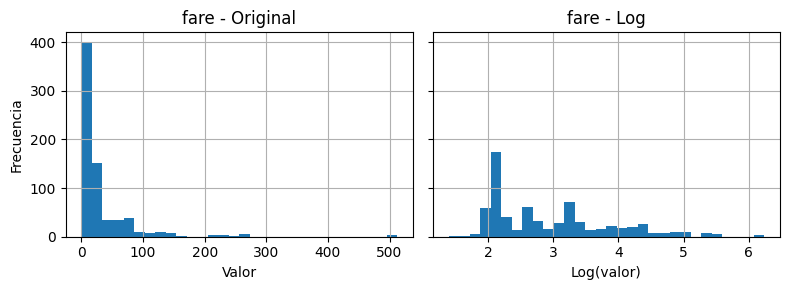

C:\Users\MarioSimarroIntelaqu\AppData\Local\Temp\ipykernel_11416\994434081.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.  1.  1. -1. -1. -1.  1. -1.  1.  1.  1. -1.  1. -1.  1. -1. -1.  1.
  1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1.  1.  1. -1.  1. -1.  1. -1.
 -1. -1. -1. -1.  1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1. -1. -1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 -1.  1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1.  1.  1.  1.  1.  1. -1.
  1. -1. -1. -1. -1. -1.  1.  1.  1. -1.  1. -1.  1. -1.  1.  1. -1.  1.
 -1. -1. -1.  1.  1. -1. -1.  1.  1.  1. -1. -1.  1. -1. -1. -1.  1.  1.
 -1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1. -1.  1. -1. -1.  1.  1. -1.
  1.  1.  1.  1.  1. -1.  1.  1. -1. -1.  1.  1.  1.  1. -1.  1.  1. -1.
  1. -1.  1.  1.  1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.  1.  1. -1.  1.  1. -1.  1.  1. -1. -1. -1.  1. -1

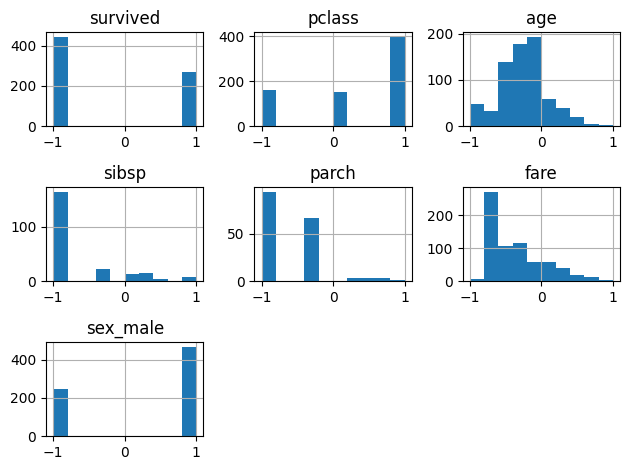

In [16]:
# Aplicamos las transformaciones necesarias. Lo hago con funciones para que me sirva luego para mi train y set

def normalizacion(df_normalized, features_num):
    """
    Normalización de las variables numéricas al rango [-1, 1].
    """
    if isinstance(features_num, str):
        features_num = [features_num]

    for feature in features_num:
        scaled_values = MinMaxScaler(feature_range=(-1, 1)).fit_transform(df_normalized[feature].values.reshape(-1, 1))
        df_normalized.loc[df_normalized.index, feature] = scaled_values.flatten()
    return df_normalized

def transf_log(df_transformed, features_num, plot=True):
    """
    Aplica transformación logarítmica a las variables especificadas y devuelve el DataFrame modificado.
    
    Parámetros:
    - df: DataFrame original.
    - features_num: Lista de columnas a transformar.
    - plot: Si True, muestra histogramas antes y después de la transformación.
    
    Retorna:
    - df: DataFrame con las columnas transformadas.
    """
    if isinstance(features_num, str):
        features_num = [features_num]

    df_transformed = df_transformed.copy()  # Para evitar modificar el original

    for feature in features_num:
        if plot:
            fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
            df_transformed[feature].hist(ax=axs[0], bins=30)
            axs[0].set_title(f"{feature} - Original")
            axs[0].set_xlabel("Valor")
            axs[0].set_ylabel("Frecuencia")

        # Transformación logarítmica segura
        df_transformed[feature] = df_transformed[feature].apply(lambda x: np.log(x) if pd.notnull(x) and x > 0 else np.nan)

        if plot:
            df_transformed[feature].dropna().hist(ax=axs[1], bins=30)
            axs[1].set_title(f"{feature} - Log")
            axs[1].set_xlabel("Log(valor)")

            plt.tight_layout()
            plt.show()
    return df_transformed


# Priemro aplicamos una transformación logarítmica a aquellas variables que tienen una distribución sesgada (heavy tail).
features_log = ["sibsp", "parch", "fare"]
train_set = transf_log(train_set, features_log)

# Ahora normalizamos las variables numéricas
features_num = train_set.columns
train_set = normalizacion(train_set, features_num)

train_set.hist()
plt.tight_layout()

9. Construye un modelo de regresión logística.

In [17]:
log_reg = LogisticRegression(max_iter = 5000)
log_reg.fit(X_train, y_train)

print(log_reg.coef_)
print(log_reg.intercept_)
print(log_reg.classes_)

[[-0.87940089 -0.01645017 -0.53340566 -0.34050503  0.00302257 -0.4944106
  -0.30003631 -0.15293295 -0.35811878 -2.43543384  0.30210531]]
[4.327231]
[0 1]


10. EXTRA: Analiza si lo crees conveniente los pesos y la importancia de las features.

In [18]:
intercept = log_reg.intercept_
coefs = log_reg.coef_.ravel()
features = pd.DataFrame(coefs, X_train.columns, columns=['coefficient']).copy()
features['coefficient'] = np.abs(features['coefficient'])
features.sort_values('coefficient', ascending=False).head()


,coefficient
who_man,2.435434
pclass,0.879401
sibsp,0.533406
alone,0.494411
embarked_S,0.358119


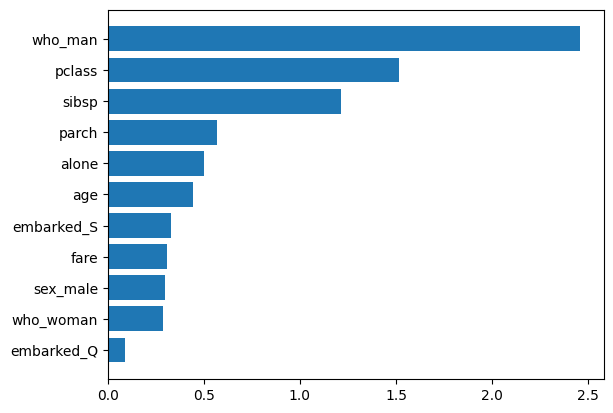

In [19]:
stdevs = []
for i in X_train.columns:
    stdev = df[i].std()
    stdevs.append(stdev)
features["stdev"] = np.array(stdevs).reshape(-1,1)
features["importance"] = features["coefficient"] * features["stdev"]
features['importance_standarized'] = features['importance'] / y_train.std()
features = features.sort_values('importance_standarized', ascending=True)
plt.barh(features.index, features.importance_standarized);



11. Procesa el dataset de Test para que puedas usarlo en la evaluación 

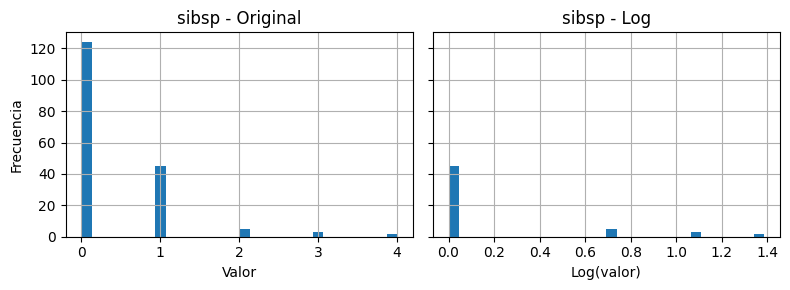

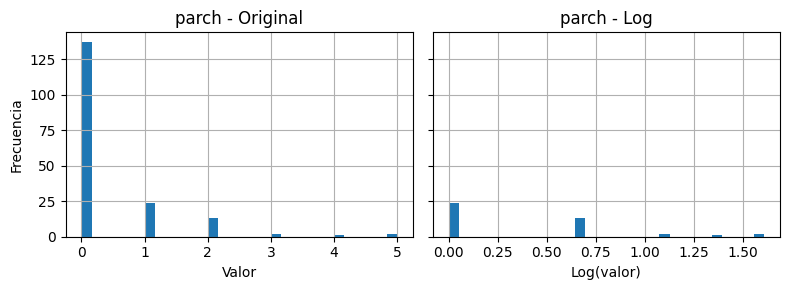

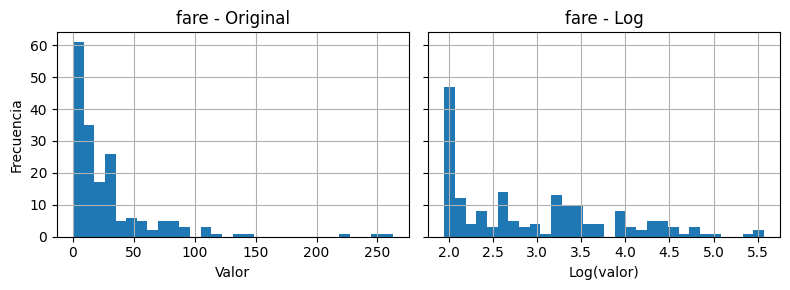

C:\Users\MarioSimarroIntelaqu\AppData\Local\Temp\ipykernel_11416\994434081.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.  1.  1. -1. -1.  1.  1. -1.  1. -1. -1.  1. -1.  1.  1. -1. -1.  1.
  1.  1.  1.  1. -1.  1.  1. -1.  1.  1. -1.  1.  1.  1.  1.  1.  1. -1.
  1.  1.  1.  1. -1. -1.  1.  1. -1. -1.  1.  1.  1. -1. -1. -1. -1. -1.
  1. -1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1.  1.  1. -1. -1. -1. -1.
  1. -1.  1. -1.  1. -1.  1. -1. -1.  1. -1.  1.  1.  1. -1.  1.  1.  1.
 -1. -1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1.  1.  1. -1. -1.  1.
  1.  1. -1.  1. -1.  1.  1.  1.  1.  1. -1. -1. -1.  1. -1. -1.  1.  1.
  1.  1. -1.  1.  1. -1.  1.  1. -1. -1.  1.  1.  1. -1.  1. -1.  1. -1.
 -1. -1.  1.  1. -1.  1.  1.  1.  1. -1.  1.  1.  1.  1. -1. -1.  1.  1.
  1. -1.  1. -1.  1. -1.  1.  1. -1. -1.  1. -1.  1.  1. -1.  1. -1.]' has dtype incompatible with bool, please explicitly cast to a

In [ ]:
# Primero aplicamos una transformación logarítmica a aquellas variables que tienen una distribución sesgada (heavy tail).
features_log = ["sibsp", "parch", "fare"]
test_set = transf_log(test_set, features_log)

# Ahora normalizamos las variables numéricas
features_num = train_set.columns
test_set = normalizacion(test_set, features_num)

12. Evalúa tu modelo contra el dataset de test y train. Obten las matrices de confusión y las métricas que creas adecuadas. Haz un pequeño assesment de su generabilidad.


In [21]:
X_test = X_test[X_train.columns].copy()

acc_train = round(accuracy_score(log_reg.predict(X_train), y_train), 3)
acc_test = round(accuracy_score(log_reg.predict(X_test), y_test), 3)
print("Accuracy train:", acc_train)
print("Accuracy test:", acc_test)


Accuracy train: 0.833
Accuracy test: 0.816


In [22]:
y_train.value_counts(True)

survived
0    0.623596
1    0.376404
Name: proportion, dtype: float64

In [23]:
y_test.value_counts(True)

survived
0    0.586592
1    0.413408
Name: proportion, dtype: float64

13. EXTRA: Halla la probabilidad de supervivencia de un hombre de entre 30 y 40 años, que embarcó en Southampton en segunda clase, viajaba solo y no pagó el billete. PISTA: En este caso tendrás que calcular varias probabilidades y hacer la media de ellas.


14. EXTRA: Aprovecha todo el trabajo haciendo un único cambio en el target, ahora será la clase del viajero. Cambia el target quitándolo de X_train, X_test y añade a estos el target anterior. El resto no deberías cambiarlo. Entrena y evalua el modelo sólo con el classification_report. 